In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.augment.spectrogram import CropTime

In [4]:
np.random.seed(1234)
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.manual_seed(1234)

In [5]:
path = Path("/home/kkalyan/agri-split/data")

In [6]:
(path/"audio_files").ls()

(#2126) [Path('/home/kkalyan/agri-split/data/audio_files/BK8UDCM.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3B5A2P3.wav'),Path('/home/kkalyan/agri-split/data/audio_files/7QXN2WO.wav'),Path('/home/kkalyan/agri-split/data/audio_files/E04FSN7.wav'),Path('/home/kkalyan/agri-split/data/audio_files/O0L4PC1.wav'),Path('/home/kkalyan/agri-split/data/audio_files/0TYHMIF.wav'),Path('/home/kkalyan/agri-split/data/audio_files/48PTKS5.wav'),Path('/home/kkalyan/agri-split/data/audio_files/J28NE2C.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3J8WKXR.wav'),Path('/home/kkalyan/agri-split/data/audio_files/67FIJLB.wav')...]

In [7]:
df = pd.read_csv(path/"Train.csv")
df.head()

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu


In [8]:
ct = CropTime(duration=1000)
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [9]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_x=ColReader("fn", pref=path), 
                 batch_tfms = [a2s],
                 item_tfms=[ResizeSignal(3000), SignalShifter(), AddNoise()],
                 get_y=ColReader("label"))

In [10]:
dbunch = auds.dataloaders(df, bs=256)

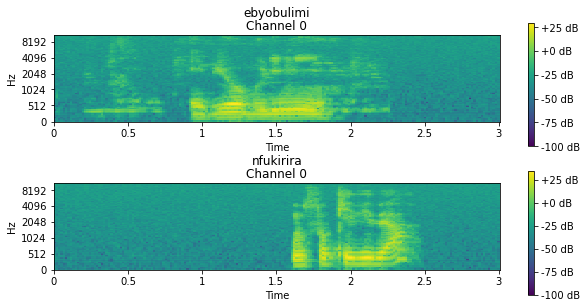

In [11]:
dbunch.show_batch(figsize=(10, 5))

In [12]:
dbunch.c

193

In [30]:
learn = cnn_learner(dbunch, 
            resnet50, 
            config=cnn_config(n_in=1),
            loss_fn=LabelSmoothingCrossEntropy,
            metrics=[accuracy, MatthewsCorrCoefMulti]).to_fp16()

In [31]:
x,y = next(iter(learn.dls.train))

In [32]:
x.shape

torch.Size([256, 1, 128, 188])

In [33]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,MatthewsCorrCoefMulti,time
0,7.104712,7.104185,0.013575,None,00:06


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.001737800776027143)

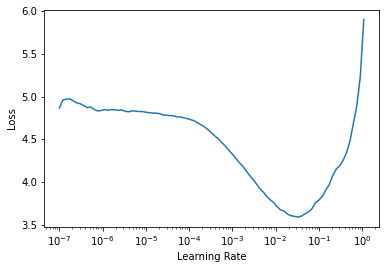

In [97]:
learn.lr_find(suggestions=True)

In [98]:
learn.fit_one_cycle(120, 1e-3, cbs=[EarlyStoppingCallback(patience=20), SaveModelCallback(fname='save-agri')])

epoch,train_loss,valid_loss,accuracy,time
0,4.712480,5.393213,0.027149,00:05
1,4.677479,5.573616,0.027149,00:05
2,4.610904,5.428234,0.027149,00:05
3,4.539623,5.567822,0.022624,00:05
4,4.458300,5.516015,0.045249,00:05
5,4.348621,5.266642,0.072398,00:05
6,4.241530,5.177963,0.081448,00:05
7,4.121957,4.998383,0.081448,00:05
8,3.993294,5.030016,0.099548,00:05
9,3.850613,5.028617,0.108597,00:05


Better model found at epoch 0 with valid_loss value: 5.393212795257568.
Better model found at epoch 5 with valid_loss value: 5.266642093658447.
Better model found at epoch 6 with valid_loss value: 5.1779632568359375.
Better model found at epoch 7 with valid_loss value: 4.998382568359375.
Better model found at epoch 10 with valid_loss value: 4.8184733390808105.
Better model found at epoch 11 with valid_loss value: 4.663792610168457.
Better model found at epoch 12 with valid_loss value: 4.642838954925537.
Better model found at epoch 13 with valid_loss value: 4.55209493637085.
Better model found at epoch 14 with valid_loss value: 4.334128379821777.
Better model found at epoch 15 with valid_loss value: 4.158045768737793.
Better model found at epoch 19 with valid_loss value: 4.077962875366211.
Better model found at epoch 22 with valid_loss value: 4.028071403503418.
Better model found at epoch 25 with valid_loss value: 3.9024322032928467.
Better model found at epoch 26 with valid_loss value:

In [99]:
# 6.484395	5.673533	0.004525	00:04

In [100]:
learn.load('save-agri')

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.5848931980144698e-06)

Exception ignored in: <function tqdm.__del__ at 0x7fd86b47d160>
Traceback (most recent call last):
  File "/home/kkalyan/miniconda3/envs/fastaudio/lib/python3.8/site-packages/tqdm/std.py", line 1087, in __del__
    self.close()
  File "/home/kkalyan/miniconda3/envs/fastaudio/lib/python3.8/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Exception ignored in: <function tqdm.__del__ at 0x7fd86b47d160>
Traceback (most recent call last):
  File "/home/kkalyan/miniconda3/envs/fastaudio/lib/python3.8/site-packages/tqdm/std.py", line 1087, in __del__
    self.close()
  File "/home/kkalyan/miniconda3/envs/fastaudio/lib/python3.8/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


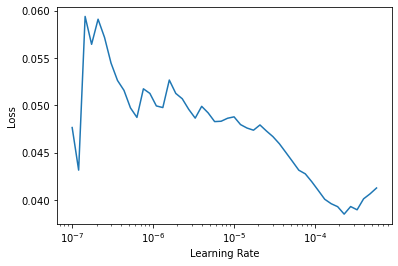

In [101]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [102]:
learn.fit_one_cycle(100, slice(1e-5, 1e-3), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-agri')])

epoch,train_loss,valid_loss,accuracy,time
0,0.047120,3.651430,0.289593,00:05
1,0.049430,3.673585,0.307692,00:05
2,0.044168,3.591343,0.312217,00:05
3,0.041586,3.630976,0.303167,00:05
4,0.038353,3.632147,0.312217,00:05
5,0.036727,3.615026,0.312217,00:05
6,0.034804,3.715823,0.307692,00:05
7,0.033285,3.704334,0.303167,00:05
8,0.031262,3.696002,0.289593,00:05
9,0.029981,3.665423,0.285068,00:05


Better model found at epoch 0 with valid_loss value: 3.651430130004883.
Better model found at epoch 2 with valid_loss value: 3.591343402862549.
No improvement since epoch 2: early stopping


SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=3.981071586167673e-06)

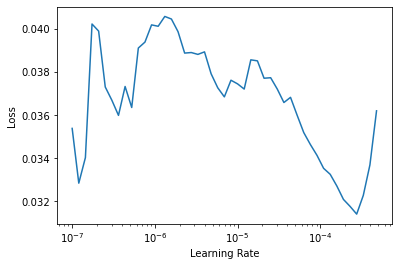

In [103]:
learn.lr_find(suggestions=True)

In [104]:
learn.load('save-agri')

In [105]:
learn.fit_one_cycle(100, slice(4e-7, 1e-5), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-agri')])

epoch,train_loss,valid_loss,accuracy,time
0,0.043068,3.671844,0.289593,00:05
1,0.041000,3.655992,0.312217,00:05
2,0.041129,3.568934,0.303167,00:05
3,0.041988,3.641341,0.298643,00:05
4,0.039702,3.631811,0.307692,00:05
5,0.040253,3.623359,0.325792,00:05
6,0.040791,3.627571,0.312217,00:05
7,0.039870,3.715755,0.294118,00:05
8,0.039947,3.650919,0.307692,00:05
9,0.039026,3.663588,0.303167,00:05


Better model found at epoch 0 with valid_loss value: 3.6718437671661377.
Better model found at epoch 1 with valid_loss value: 3.655991792678833.
Better model found at epoch 2 with valid_loss value: 3.568934202194214.
No improvement since epoch 2: early stopping


SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=3.311311274956097e-06)

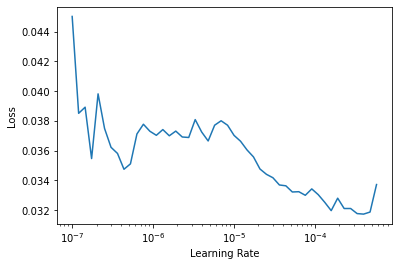

In [106]:
learn.lr_find(suggestions=True)

In [107]:
learn.load('save-agri')

In [108]:
learn.fit_one_cycle(100, slice(1e-8, 1e-6), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-agri')])

epoch,train_loss,valid_loss,accuracy,time
0,0.040287,3.710469,0.289593,00:05
1,0.044014,3.683320,0.289593,00:05
2,0.042969,3.756850,0.289593,00:05
3,0.040731,3.658882,0.280543,00:05
4,0.039377,3.544313,0.325792,00:05
5,0.040617,3.815058,0.285068,00:05
6,0.039157,3.635209,0.312217,00:05
7,0.037871,3.709930,0.312217,00:05
8,0.037509,3.586774,0.307692,00:05
9,0.037371,3.732398,0.289593,00:05


Better model found at epoch 0 with valid_loss value: 3.7104687690734863.
Better model found at epoch 1 with valid_loss value: 3.683319568634033.
Better model found at epoch 3 with valid_loss value: 3.6588821411132812.
Better model found at epoch 4 with valid_loss value: 3.5443129539489746.
No improvement since epoch 4: early stopping


In [109]:
learn.load('save-agri')

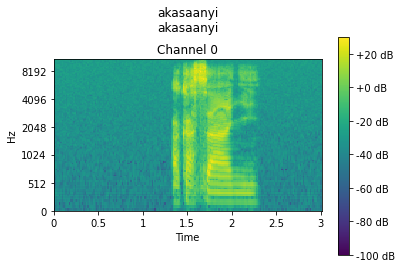

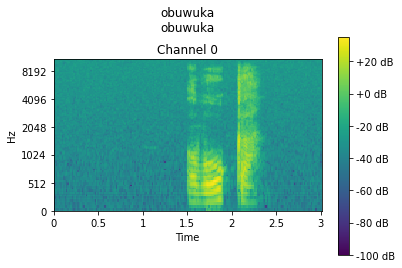

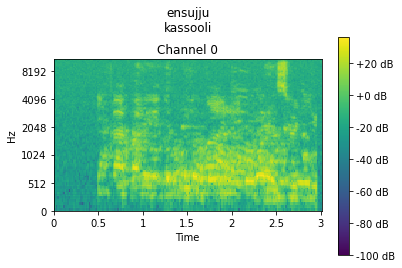

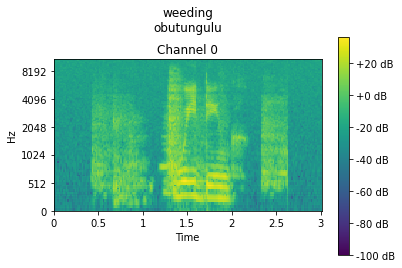

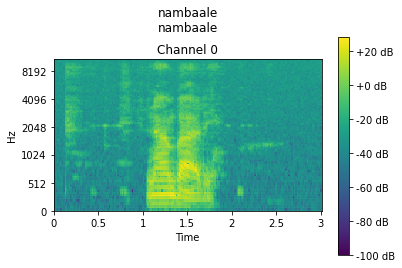

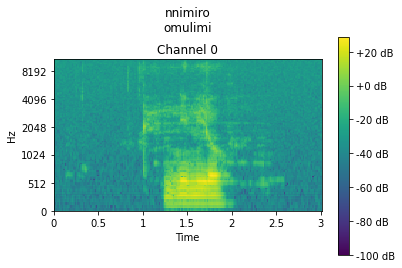

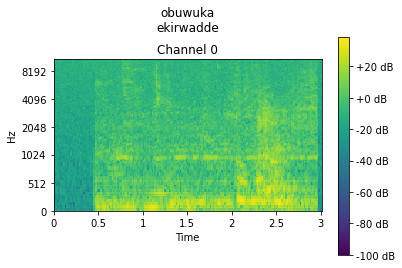

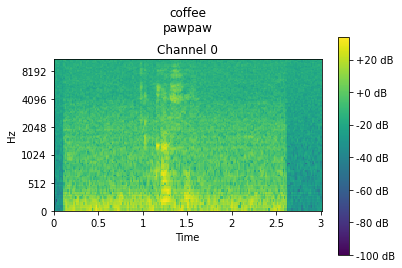

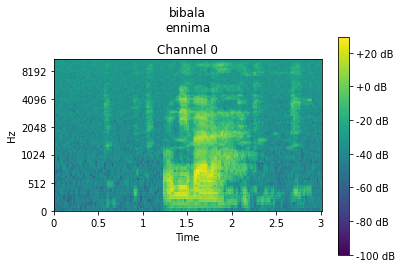

In [110]:
learn.recorder.show_results()

In [111]:
interp = ClassificationInterpretation.from_learner(learn)

In [112]:
# Find Result
# Kfold CV

In [113]:
interp.most_confused()

[('kasaanyi', 'kisaanyi', 3),
 ('ebisoolisooli', 'eppapaali', 2),
 ('eddagala', 'ddagala', 2),
 ('obuwuka', 'ekirwadde', 2),
 ('Pump', 'plant', 1),
 ('abalimi', 'dig', 1),
 ('akammwanyi', 'kassooli', 1),
 ('akatunda', 'ebibala', 1),
 ('akatungulu', 'amappapaali', 1),
 ('akawuka', 'harvesting', 1),
 ('amakoola', 'amakungula', 1),
 ('amakoola', 'ensigo', 1),
 ('amakungula', 'akawuka', 1),
 ('amalagala', 'ebijanjaalo', 1),
 ('amalagala', 'lusuku', 1),
 ('amatooke', 'amappapaali', 1),
 ('amatooke', 'ebitooke', 1),
 ('banana', 'weeding', 1),
 ('bibala', 'emicungwa', 1),
 ('bibala', 'ennima', 1),
 ('cassava', 'akammwanyi', 1),
 ('crop', 'okulimibwa', 1),
 ('ddagala', 'ndwadde', 1),
 ('disease', 'leaves', 1),
 ('drought', 'crop', 1),
 ('drought', 'worm', 1),
 ('ebbugga', 'doodo', 1),
 ('ebbugga', 'ndwadde', 1),
 ('ebigimusa', 'ndwadde', 1),
 ('ebijjanjalo', 'mucungwa', 1),
 ('ebikajjo', 'ebisooli', 1),
 ('ebikolo', 'ekimera', 1),
 ('ebikoola', 'ebibala', 1),
 ('ebikoola', 'okufukirira', 1),
 

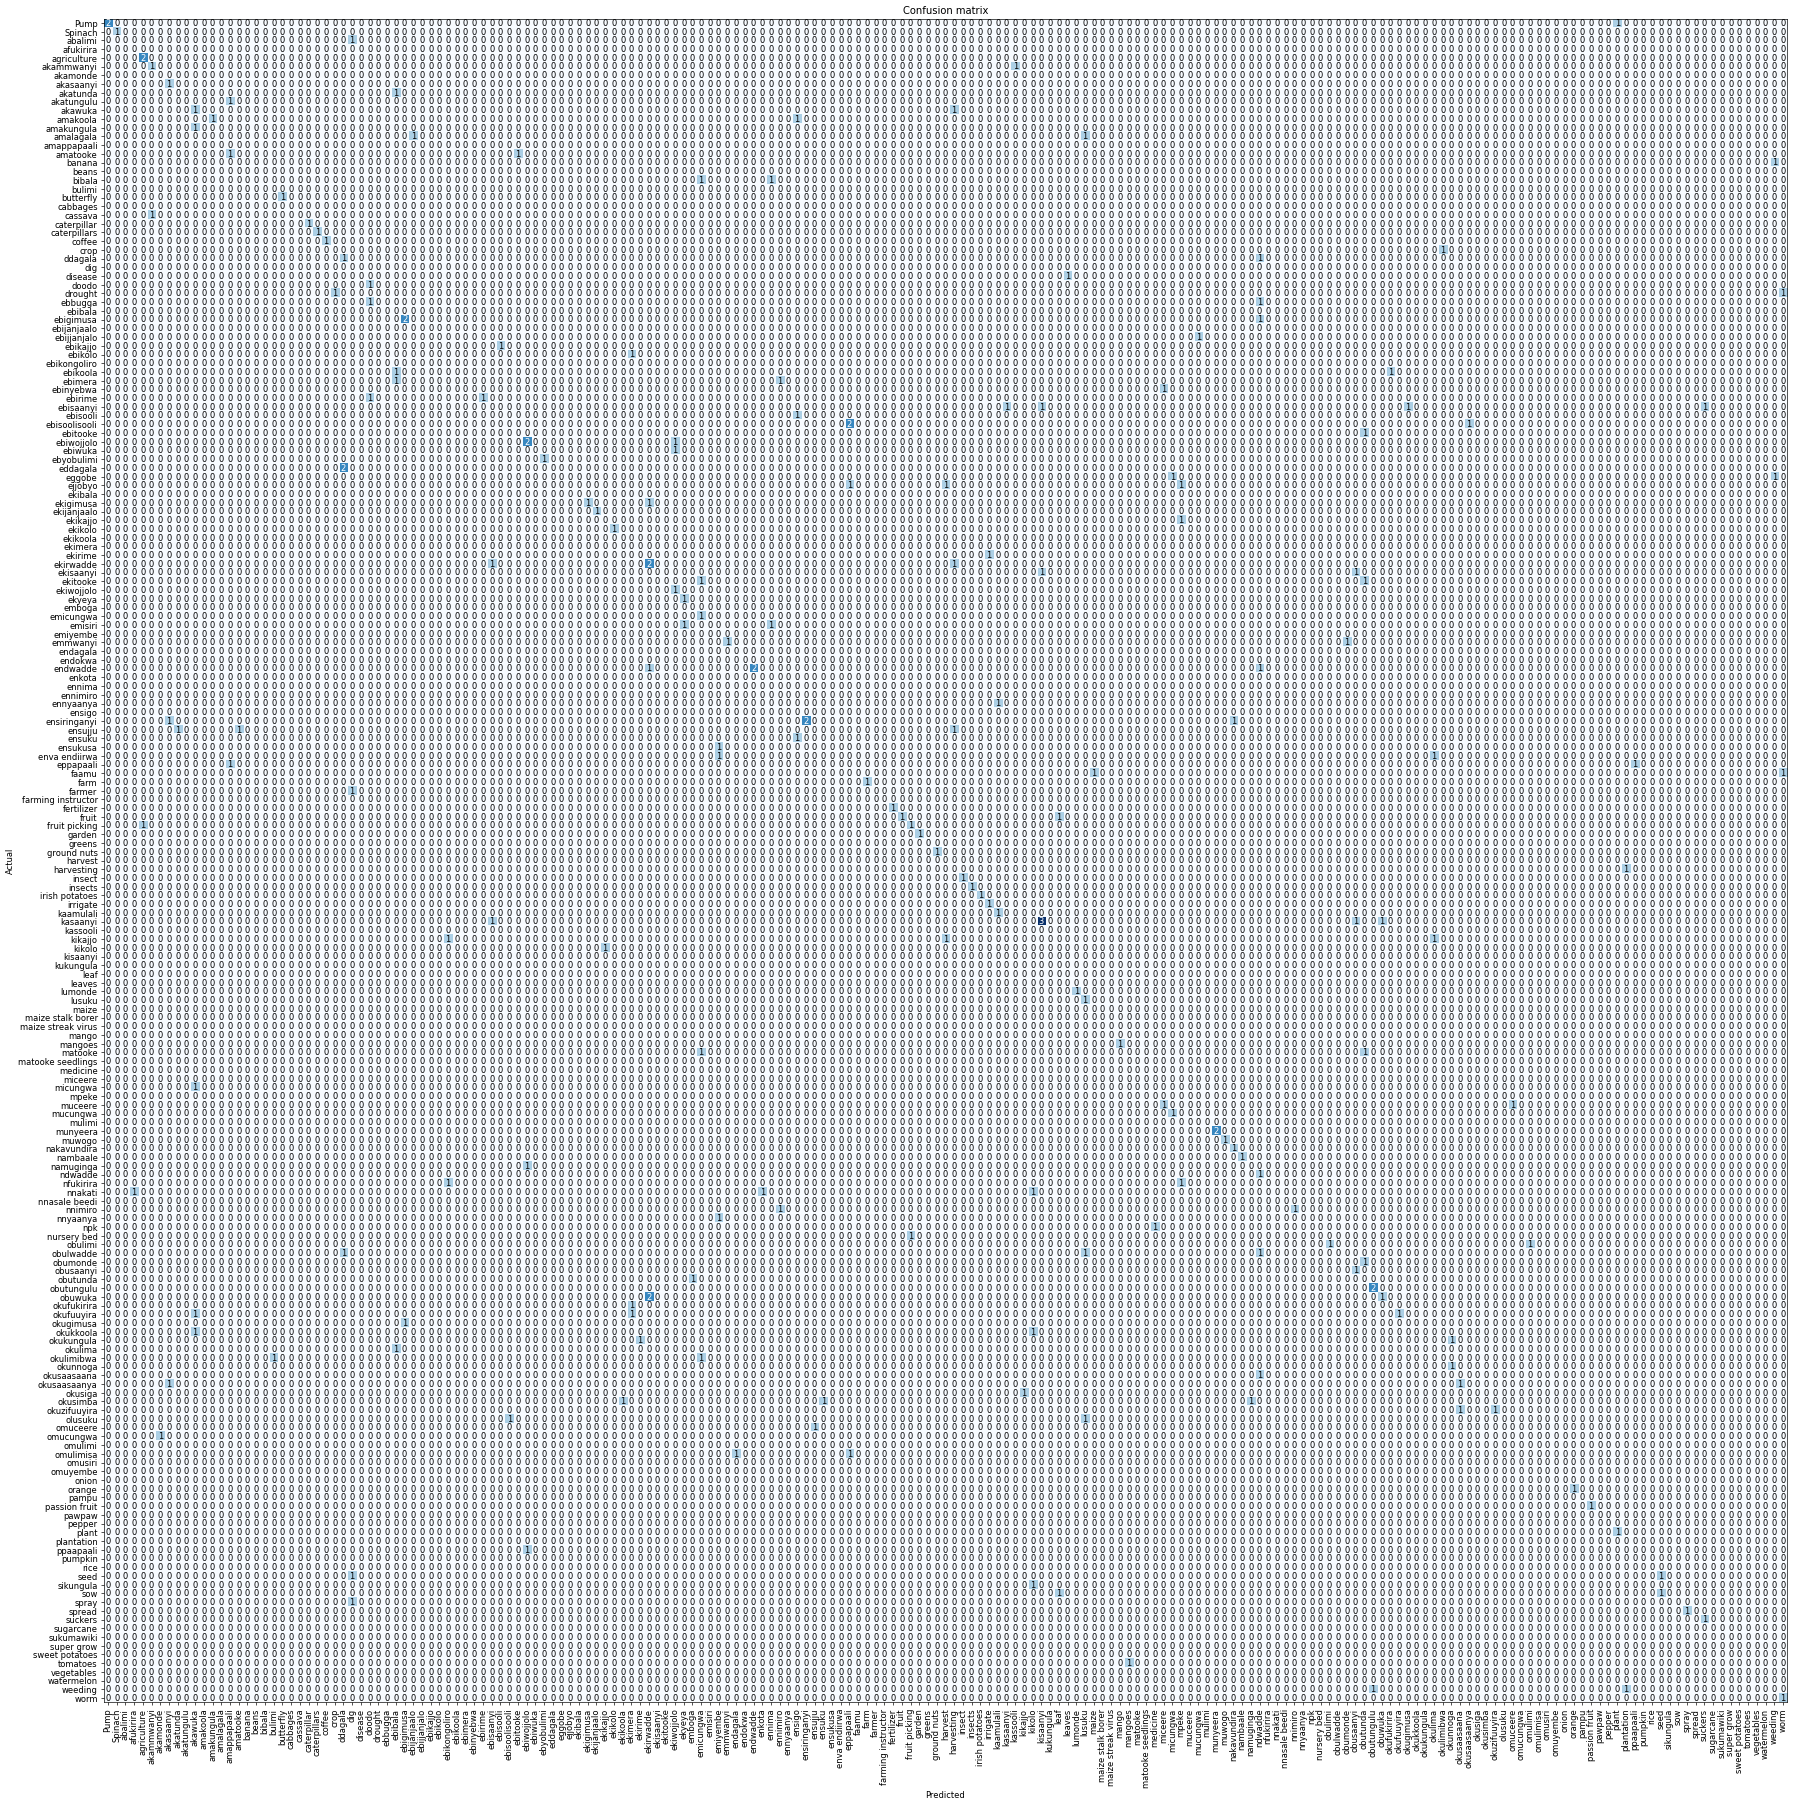

In [114]:
interp.plot_confusion_matrix(figsize=(30,30), dpi=60)

In [115]:
learn.eval()

AttributeError: 'Learner' object has no attribute 'eval'

In [ ]:
preds, y = learn.get_preds(dl=dbunch.valid)
acc = accuracy(preds, y)

In [ ]:
acc

In [ ]:
#dbunch.valid_ds.cat

In [ ]:
ac_1 = learn.validate(); ac_1

In [ ]:
y.shape

In [ ]:
preds.shape

In [ ]:
ss = pd.read_csv('SampleSubmission.csv')

tdl = learn.dls.test_dl(ss['fn'].values, order=True)
test_preds, test_labels = learn.get_preds(dl=tdl)

In [ ]:
for i, label in enumerate(dbunch.vocab):
    ss[label] = [np.round(t[i].numpy(), 4) for t in test_preds]
ss.head()
ss.to_csv('Submission_large_bs.csv', index=False)

In [ ]:
# 3.68267962125371